# Exercise: MLP

The goal of today's session is to get you familiar with neural networks, backpropragation and training. To do that, we will not use any external libraries and we will code from scratch a multilayer perceptron (MLP).

After this session, we will use standard deep learning libraries, as coding a neural network from scratch is not that easy, as you will see.

In [49]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# 1 Activation functions

Activation functions introduce non-linearities in our network. They are a fundamental ingredient in a neural networks, as they allow them to learn highly non-linear mappings between the input and the target domains.

For now we will look at the classical sigmoid activation function, defined as 

\begin{align}
S(z) = \frac{1}{1 + e^{-z}}.
\end{align}

To train our networks, we will need to compute its derivative:

\begin{align}
\frac{dS}{dz}(z) = \frac{d}{dz} \left( \frac{1}{1 + e^{-z}} \right) = -1 (1 + e^{-z})^{-2} (-e^{-z}) = \frac{e^{-z}}{(1 + e^{-z})^2} = S(z)(1-S(z))
\end{align}

Implement the sigmoid function and its gradient below:

In [50]:
class Sigmoid:
    @staticmethod
    def forward(z):
        return 1/(1+np.exp(-z))

    @staticmethod
    def gradient(z):
        return (np.exp(-z))/(1+np.exp(-z))**2

When you are done, you can test your implementation by running the code below.

Pay attention to how we call the `forward` and `gradient` functions for these classes.

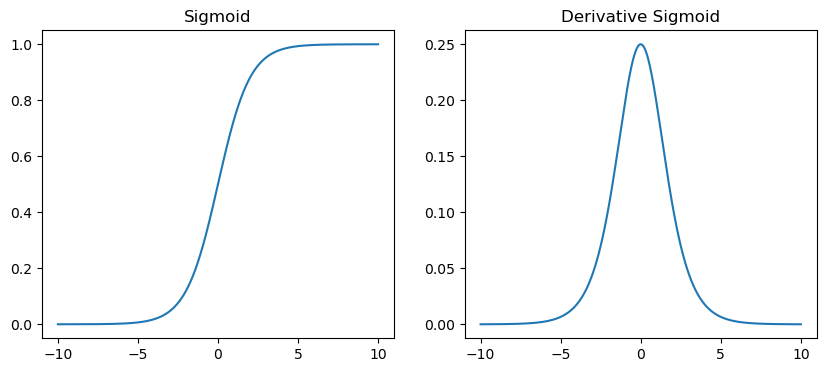

In [51]:
z = np.linspace(-10,10,1000)
S = Sigmoid.forward(z)
dS_dz = Sigmoid.gradient(z)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(z, S)
plt.title('Sigmoid')

plt.subplot(122)
plt.plot(z, dS_dz)
plt.title('Derivative Sigmoid')
plt.show()

Another very popular activation function, the Rectified Linear Unit (ReLU), is defined as 

\begin{align}
ReLU(z) = \begin{cases}
               0               & z<0\\
               z               & z\geq 0\\ \end{cases}
\end{align}

and its (sub-)derivative reads:

\begin{align}
\frac{d ReLU}{dz}(z) = \begin{cases}
               0               & z<0\\
               1               & z\geq 0\\ \end{cases}
\end{align}

Implement this function and its derivative below:

In [52]:
class ReLU:
    @staticmethod
    def forward(z):
        return (z>=0)*z

    @staticmethod
    def gradient(z):
        return (z>=0)

When you are done, you can test your implementation by running the code below:

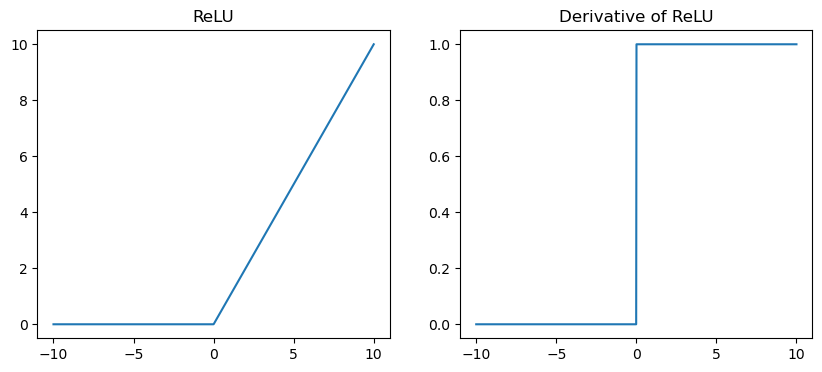

In [53]:
z = np.linspace(-10,10,1000)
T = ReLU.forward(z)
dT_dz = ReLU.gradient(z)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(z, T)
plt.title('ReLU')

plt.subplot(122)
plt.plot(z, dT_dz)
plt.title('Derivative of ReLU')
plt.show()

# 2 Network

We will now define our first neural network through the `Network` class.

We implemented for you the constructor of the class, which takes as input a specification of the dimension of each layer $l$ and a list of per-layer activation functions (so that each layer can have a different activation function). 

The initializations for our network are done in the following way:

$$\begin{align}
b^{(l)}_j &= 0 \, \, \, j=1,\dots,J \\
W^{(l)}_{ji} &= \frac{\mathcal N(0,1)}{\sqrt{I}}  \, \, \, i=1,\dots,I \, \, \,  j=1,\dots,J
\end{align}$$

where $I, J$ are the number of neurons respectively at the input/output of the $l$-th layer. $W^{(l)}_{ji}$ denotes the **weight** from node $i$ to $j$ in layer $l$ and $b^{(l)}_j$ is the **bias** term for layer $l$, node $j$.

You will have to implement the forward pass of the network, which generates its output $\mathbf{y}$.
Specifically, the input is fed to the network and recursively multiplied with the weights of every layer $l$.
The mathematics of the forward pass are the same for every layer $l$. 
Using the notation we introduced, this can be written as 

$$\begin{align}
\mathbf{a}^{(l)} &= \mathbf{W}^{(l)} \mathbf{z}^{(l-1)} + \mathbf{b}^{(l)}\;. \\
\end{align}$$

Followed by the nonlinear activation 
$$\begin{align}
\mathbf{z}^{(l)} &= \sigma^{(l)}(\mathbf{a}^{(l)})
\end{align}$$
where $\sigma^{(l)}$ denotes the activation function for layer $l$, which is applied independently to every element of the vector $\mathbf{a}^{(l)}$. $\mathbf{z}^{(l)}$ is then the output of layer $l$, and we denote by $\mathbf{z}^{(0)}=\mathbf{x}$ the input (i.e., we can think of the input to the network as the output of a layer $0$).

Implement the forward pass in the method `feed_forward()` below, which takes as input $\mathbf{x}$, returns $\mathbf{a}$ and $\mathbf{z}$, two dictionaries containing the outputs and activations for every layer. Keeping track of computed quantities will be useful for training the model. 

Method `predict()`, which we have implemented for you, is just a wrapper around `feed_forward()` yielding the output of our network. 

**NOTE:** we use batched input $\mathbf{X}$, i.e., it is not a single vector but a matrix of multiple data points of shape $(N\times D)$. In that case, the computation of each layer's activation can be re-written as:
$$\begin{align}
\mathbf{A}^{(l)} &= \mathbf{Z}^{(l-1)} \mathbf{W}^{(l)\top} + \mathbf{b}^{(l)}\;. \\
\end{align}$$


In [54]:
class Network:

    def __init__(self, dimensions, activations):
        """
        :param dimensions: list of dimensions of the neural net. (input, hidden-layer, ..., hidden-layer, output)
        :param activations: list of activation functions. Must contain N-1 activation function, where N = len(dimensions).
        
        Example of an MLP with 2 inputs, 10 hidden nodes and 5 outputs:
            dimensions =  (2,       10,          5)
            activations = (    Sigmoid,    Sigmoid)
        which corresponds to the layers:
            layers -->    [0,        1,          2]
        """
        self.n_layers = len(dimensions)
        self.loss = None
        self.learning_rate = None
        
        # Weights and biases are indexed by layer l.
        self.w = {}
        self.b = {}
        # Activations are also indexed by layer l. 
        self.activations = {}

        for l in range(1, self.n_layers):
            self.w[l] = np.random.randn(dimensions[l], dimensions[l-1]) / np.sqrt(dimensions[l - 1])
            self.b[l] = np.zeros(dimensions[l])
            self.activations[l] = activations[l-1]


    def feed_forward(self, x):
        """
        Execute a forward feed through the network.
        :param x: (array) Batch of input data vectors.
        :return: (tpl) Node outputs and activations per layer. The numbering of the output is equivalent to the layer numbers.
        """
        # a = Wx + b
        a = {}

        # z = sigma(a)
        z = {0: x}  # First layer := input layer
        
        for l in range(1, self.n_layers):
            # current layer = l
            ### WRITE YOUR CODE HERE
            a[l] = np.dot(self.w[l],z[l-1].T) + self.b[l].reshape(-1, 1)
            z[l] = self.activations[l].forward(a[l]).T

            


        return a, z
    
    def predict(self, x):
        """
        :param x: (array) Containing parameters
        :return: (array) A 2D array of shape (n_cases, n_classes).
        """
        _, z = self.feed_forward(x)
        return z[self.n_layers - 1]
    

    def back_prop(self, a, z, y_true):
        """
        Back-propagation algorithm.
        The input dicts keys represent the layers of the net.
        :param a: (dict) Wx + b
        :param z: (dict) sigma(a)
        :param y_true: (array) One hot encoded ground-truth vector.
        :return:
        """
        # Determine partial derivative and delta for the output layer.
        y_pred = z[self.n_layers - 1]
        delta = self.loss_function.gradient(y_true, y_pred) * self.activations[self.n_layers - 1].gradient(y_pred)
        
        dw = np.dot(delta.T, z[self.n_layers - 2])

        update_params = {
            self.n_layers - 1: (dw, delta)
        }

        # Determine partial derivative and delta for the rest of the layers.
        # Each iteration requires the delta from the previous layer, propagating backwards.
        for l in reversed(range(1, self.n_layers - 1)):
            delta = np.dot(delta, self.w[l+1]) * self.activations[l].gradient(a[l]).T
            dw = np.dot(delta.T, z[l - 1])
            update_params[l] = (dw, delta)
        
        # finally update weights and biases
        for k, v in update_params.items():
            self.update_w_b(k, v[0], v[1])

    def update_w_b(self, index, dw, delta):
        """
        Update weights and biases.
        :param index: (int) Number of the layer
        :param dw: (array) Partial derivatives
        :param delta: (array) Delta error.
        """
        self.w[index] -= self.learning_rate * dw
        self.b[index] -= self.learning_rate * np.mean(delta, 0)

    def fit(self, x, y_true, loss, epochs, batch_size, learning_rate=1e-3):
        """
        :param x: (array) Containing parameters
        :param y_true: (array) Containing one hot encoded labels.
        :param loss: Loss class (MSE, CrossEntropy etc.)
        :param epochs: (int) Number of epochs.
        :param batch_size: (int)
        :param learning_rate: (flt)
        """
        if not x.shape[0] == y_true.shape[0]:
            raise ValueError("Length of x and y arrays don't match")
        # Initiate the loss object with the final activation function
        self.loss_function = loss
        self.learning_rate = learning_rate

        for i in range(epochs):
            # Shuffle the data
            indices = np.arange(x.shape[0])
            np.random.shuffle(indices)
            x_ = x[indices]
            y_ = y_true[indices]

            for j in range(x.shape[0] // batch_size):
                k = j * batch_size
                l = (j + 1) * batch_size
                a, z = self.feed_forward(x_[k:l])
                self.back_prop(a, z, y_[k:l])

            if (i + 1) % 10 == 0:
                _, z = self.feed_forward(x)
                print("Loss at epoch {}: {}".format(i + 1, self.loss_function.loss(y_true, z[self.n_layers - 1])))

You have now created your first neural network, which can produce outputs based on inputs. 
To make sure everything is right, you can run the cell below. It will define a network with 1 input layer, 1 hidden layer and 1 output layer, with 1 node each. This is defined by the `dimensions` parameter, as `(1, 1, 1)`. The activation functions of the hidden layer and output layer are both sigmoid, defined by the `activations` parameter as `(Sigmoid, Sigmoid)`. 

We then generate a random input `x` and pass it through the `feed_forward()` function of the `Network` object. This produces two outputs `z` and `a` which are both dictionaries containing the `z` and `a` values the network computes. You will be seeing the following dictionary outputs:

```python
a:
{
	1: "values of the hidden layer", 
	2: "values of the output layer"
}

z:
{
	0: "inputs x",
	1: "activations in the hidden layer",
	2: "activations in the output layer"
}
```

In [55]:
# initialize  network structure
nn = Network(dimensions=(1, 1, 1), activations=(Sigmoid, Sigmoid))
x = np.random.rand(1,1)
a, z = nn.feed_forward(x)
print(a)
print(z)

{1: array([[-0.1612296]]), 2: array([[-0.62060948]])}
{0: array([[0.32582356]]), 1: array([[0.45977969]]), 2: array([[0.34964285]])}


# 3 Loss Function

Loss functions map the predictions of our network into a real number, measuring the error in our predictions.

In this first session we will take the Mean Squared Error (MSE) as our loss function.

Let $\mathbf{y}_n \in \mathbb{R}^K$ be the prediction generated by our network for $n$-th data sample, and $\mathbf{Y} \in \mathbb{R}^{N \times K}$ be the matrix of N predictions generated for $N$ data points.

Similarly let $\mathbf{T} \in \mathbb{R}^{N \times K}$ be the matrix of true labels $\mathbf{t}_n \in \mathbb{R}^ K$.

We then define the Mean Squared Error (MSE) of the predictor as

$$\begin{align}
\mathcal{L}_{\text{MSE}} = \frac{1}{NC} \sum_{n=1}^{N} \sum_{k=1}^{C} \left(y_{n}^{(k)}-{t_{n}^{(k)}}\right)^{2}.
\end{align}$$

We can compute its derivative w.r.t. the predictions $y_{n}^{(k)}$ as

$$\begin{align}
\frac{\partial \mathcal{L}_{\text{MSE}}}{\partial y_{n}^{(k)}} = \frac{2}{NC} \left(y_{n}^{(k)}-{t_{n}^{(k)}}\right).
\end{align}$$

Re-writing this in matrix form gives

$$\begin{align}
\frac{\partial \mathcal{L}_{\text{MSE}}}{\partial \mathbf{Y}} = \frac{2}{NC} \left(\mathbf{Y}-\mathbf{T}\right).
\end{align}$$

Implement this loss function and its derivatives in matrix form below:

In [56]:

class MSE:
    @staticmethod
    def loss(y_true, y_pred):
        return ((y_true - y_pred)**2)*1/(np.size(y_true))

    @staticmethod
    def gradient(y_true, y_pred):
        return 2/(np.size(y_pred-y_true)) * (y_pred - y_true)


# 4 Training your network

The loss function $\mathcal{L}$ gives us information about the prediction error of the model. Our goal is to minimize the loss function by optimizing the weights and biases. 

We know from calculus that if we take the partial derivative of the loss function with respect to a certain weight $W^{(l)}_{ji}$, we get the rate of increase of $\mathcal{L}$ in that direction. 

The opposite direction of $\frac{\partial \mathcal{L}}{\partial W^{(l)}_{ji}}$ will then point in the direction that minimizes the loss function.
We can therefore, choosing a step size $\eta$, reduce the loss function by updating our weight as follows
$$\begin{align}
W^{(l)}_{ji} = W^{(l)}_{ji} - \eta \frac{\partial \mathcal{L}}{\partial W^{(l)}_{ji}}
\end{align}$$
This weight optimization is called gradient descent and is done w.r.t. every weight and bias of the network.

To determine the partial derivative of $\mathcal{L}$ with respect to a certain weight, we can apply the chain rule in differentiation

$$\begin{align}
\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} \frac{\partial y}{\partial x}
\end{align}$$

In practice this allows us to break down the problem within each layer. We call the whole process backpropagation.


To understand backpropagation, we will take a step back and consider a very simple neural network with one hidden layer (with a single node) taking scalar input $x \in \mathbb{R}$ and outputting a scalar $y \in \mathbb{R}$

$$\begin{align}
a^{(1)} &= W^{(1)} x + b^{(1)} \\
z^{(1)} &= \sigma(a^{(1)}) \\
a^{(2)} &= W^{(2)} z^{(1)} + b^{(2)} \\
y &= \sigma(a^{(2)}) \\
\mathcal{L} &= (y-t)^2
\end{align}$$

Using the chain rule, compute derivatives of $\mathcal{L}$ with respect to all weights and biases:
$$\begin{align}
\frac{\partial \mathcal{L}}{\partial y} &= 2 (y-t) \\
\frac{\partial \mathcal{L}}{\partial a^{(2)}} &= \frac{\partial \mathcal{L}}{\partial y} \frac{\partial y}{\partial a^{(2)}} = 2 (y-t) \cdot \sigma'(a^{(2)}) \\
\frac{\partial \mathcal{L}}{\partial W^{(2)}} &= \frac{\partial \mathcal{L}}{\partial a^{(2)}} \frac{\partial a^{(2)}}{\partial W^{(2)}} = 2 (y-t) \cdot \sigma'(a^{(2)}) \cdot z^{(1)} \\
\frac{\partial \mathcal{L}}{\partial b^{(2)}} &= \frac{\partial \mathcal{L}}{\partial a^{(2)}} \frac{\partial a^{(2)}}{\partial b^{(2)}} = \cdots \\
\frac{\partial \mathcal{L}}{\partial z^{(1)}} &= \frac{\partial \mathcal{L}}{\partial a^{(2)}} \frac{\partial a^{(2)}}{\partial z^{(1)}} = \cdots \\
\frac{\partial \mathcal{L}}{\partial a^{(1)}} &= \cdots \\
\frac{\partial \mathcal{L}}{\partial W^{(1)}} &= \cdots \\
\frac{\partial \mathcal{L}}{\partial b^{(1)}} &= \cdots
\end{align}$$

As things get quite tricky with indices, we have implemented backpropagation for you in method `Network.back_prop()`. Look at it and convince yourself that it generalizes the derivations above to the multi-dimensional case. 

# 5 Fitting your model to MNIST

Now that you have implemented your first neural network, and have understood backpropagation, we will fit our model to the MNIST dataset.

The MNIST database contains a total of 70,000 handwritten digits with 10 different classes, from 0 to 9. 60,000 examples are taken as training dataset and the remaining 10,000 as testing set. The digits have been size-normalized and centered in a fixed-size image. 

We can also sub-sample the data so that our code will run faster.

First download MNIST from: https://www.python-course.eu/data/mnist/mnist_train.csv
and https://www.python-course.eu/data/mnist/mnist_test.csv
and put these 2 csv files in the same folder as your jupyter notebook file.

To make sure everything went well, we will first load the dataset and visualize some samples from it. It might take a while to load it into memory!

In [57]:
# load the dataset
# URLs for the MNIST dataset
import requests

# URLs for the MNIST dataset
train_data_url = "https://www.python-course.eu/data/mnist/mnist_train.csv"
test_data_url = "https://www.python-course.eu/data/mnist/mnist_test.csv"

def download_file(url, filename):
    response = requests.get(url)
    with open(filename, 'wb') as file:
        file.write(response.content)

# Download the MNIST dataset
train_data_file = "mnist_train.csv"
test_data_file = "mnist_test.csv"

download_file(train_data_url, train_data_file)
download_file(test_data_url, test_data_file)

image_size = 28 # width and length
no_of_different_labels = 10  # i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
train_data = np.loadtxt("mnist_train.csv", delimiter=",")
test_data = np.loadtxt("mnist_test.csv", delimiter=",") 

# Sub-sample the data. You can comment these lines out if you want to use the full dataset.
train_data = train_data[::5]
test_data = test_data[::5]

x_train = np.asfarray(train_data[:, 1:])
x_test = np.asfarray(test_data[:, 1:])
y_train = np.asfarray(train_data[:, :1])
y_test = np.asfarray(test_data[:, :1])
# transform labels into one hot representation
classes = np.arange(no_of_different_labels)
y_train = (classes == y_train).astype(float)
y_test = (classes == y_test).astype(float)

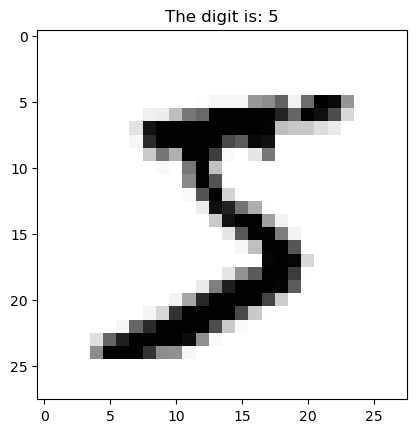

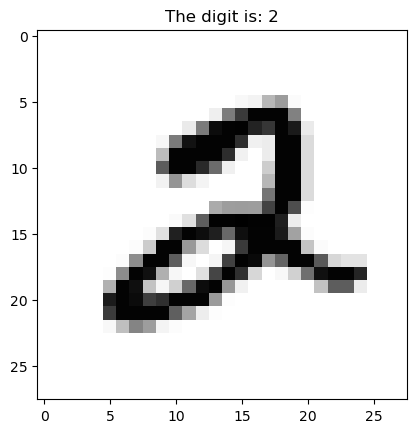

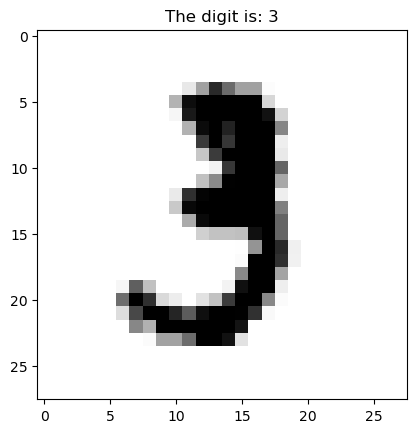

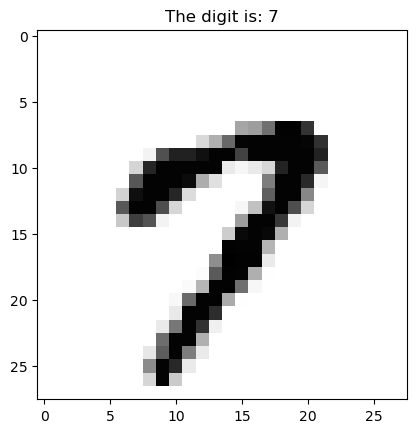

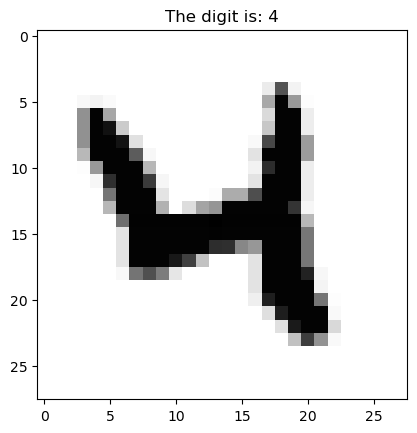

In [58]:
# visualize the image and label from the training set
for idx in range(5):
    example_img = np.resize(x_train[idx], (28,28))
    plt.title(f'The digit is: {y_train[idx].argmax()}')
    plt.imshow(example_img,cmap="Greys")
    plt.show()

You are now ready to fit your model to MNIST. Start by considering a simple one hidden layer MLP with the following specifications:

In [59]:
dimensions =  (28*28,    20,       10)
activations = (        ReLU,  Sigmoid)
epochs = 100
batch_size = 128
learning_rate = 1e-2

Using the Network class implemented above, initialize the network and fit it to the dataset using the MSE loss

In [60]:
# initialize  network structure
nn = Network(dimensions, activations)
# fit network to training data
nn.fit(x_train, y_train, loss=MSE, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate)

Loss at epoch 10: [[6.97866847e-08 5.14962503e-08 4.47109187e-08 ... 6.68870122e-08
  3.78763324e-08 2.87989620e-08]
 [1.51135078e-07 1.19484032e-07 6.55104517e-06 ... 1.46262065e-07
  9.41579517e-08 7.60866869e-08]
 [4.13608705e-08 2.91711485e-08 2.48065511e-08 ... 3.93912174e-08
  2.05115239e-08 1.49907431e-08]
 ...
 [6.58066369e-08 4.83106520e-08 7.19413331e-06 ... 6.30268845e-08
  3.53518640e-08 2.67586883e-08]
 [3.00751225e-07 2.53311954e-07 2.33811392e-07 ... 2.93640840e-07
  2.12778806e-07 6.05239381e-06]
 [2.55814785e-07 2.12250793e-07 1.94547499e-07 ... 2.49243763e-07
  6.08956629e-06 1.48162358e-07]]
Loss at epoch 20: [[2.35589622e-08 6.17985678e-08 4.52557137e-08 ... 5.08623979e-08
  7.58646496e-08 5.02335183e-08]
 [1.02882568e-07 1.96927431e-07 6.18507888e-06 ... 1.72853397e-07
  2.25820646e-07 1.71412440e-07]
 [1.65615196e-08 4.67316827e-08 3.34129701e-08 ... 3.78888776e-08
  5.82914819e-08 3.73850053e-08]
 ...
 [2.90120031e-08 7.28609633e-08 7.04429073e-06 ... 6.05055302e

Similarly to previous exercise sessions, let's define a metric to measure the accuracy of our predictions

In [61]:
def accuracy(prediction, ground_truth):
    match = prediction.argmax(axis=1) == ground_truth.argmax(axis=1)
    return np.mean(match) * 100

We can then look at how our network is performing

Loss on TEST split: 0.000004
Accuracy on TEST split: 33.8%
------------------------


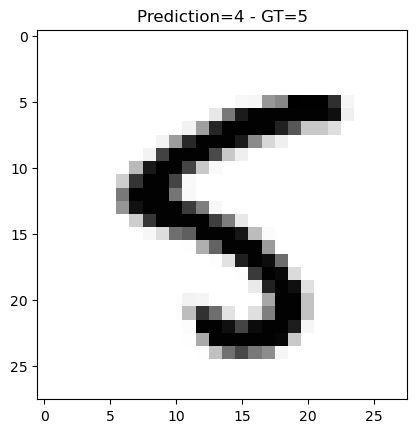

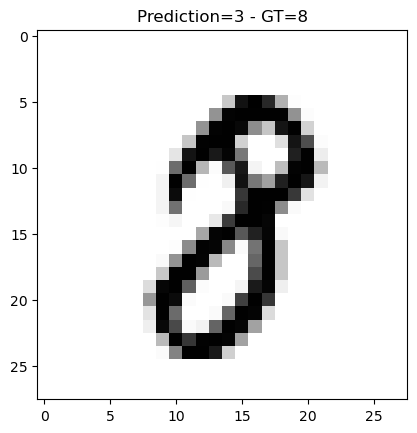

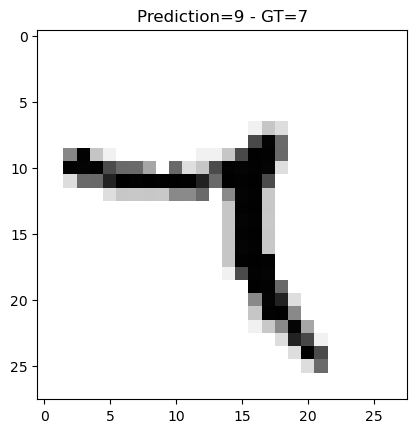

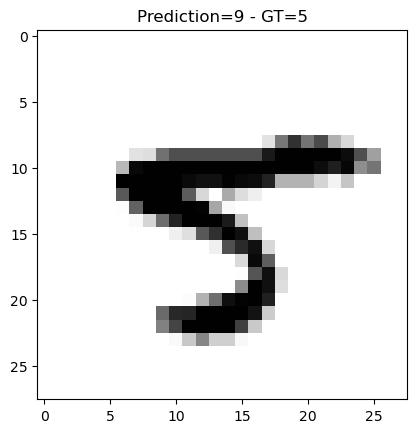

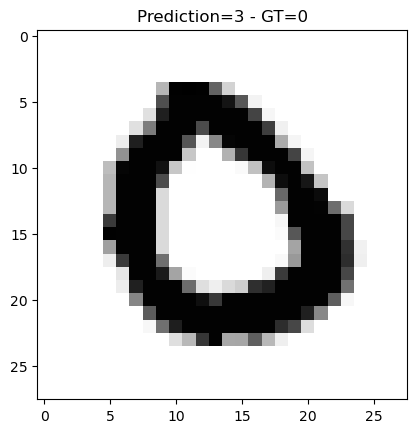

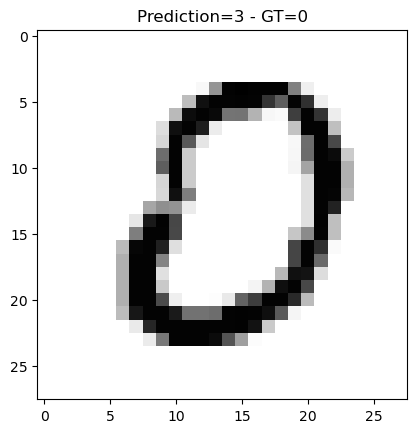

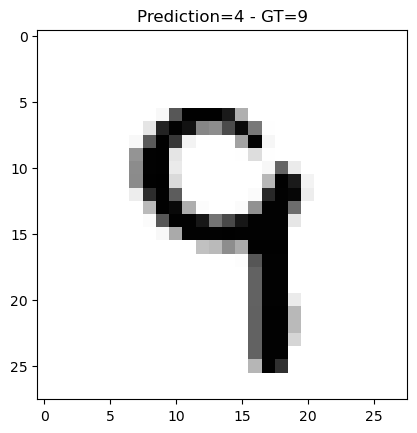

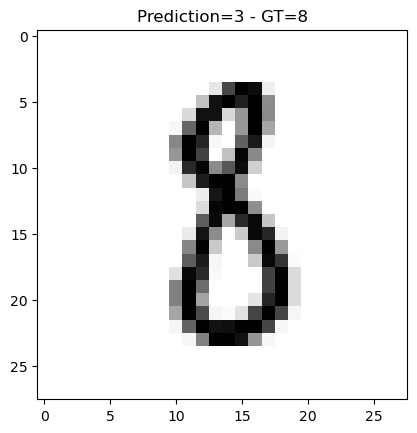

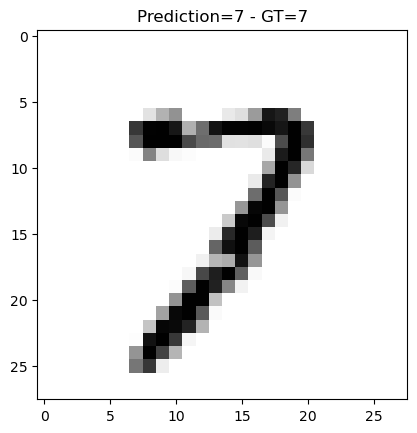

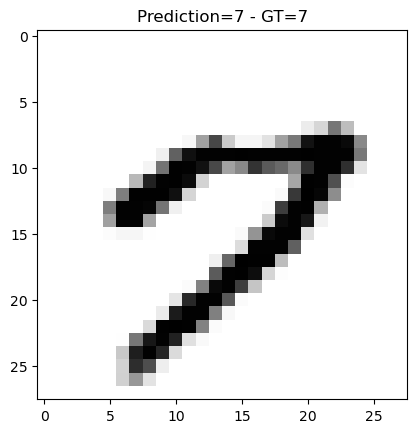

In [63]:
# predict on testing split
prediction = nn.predict(x_test)

# compute mean loss and accuracy
mean_loss = np.mean(MSE.loss(prediction, y_test))
mean_accuracy = np.mean(accuracy(prediction, y_test))

print("Loss on TEST split: {:.6f}".format(mean_loss))
print("Accuracy on TEST split: {:.1f}%".format(mean_accuracy))


print("------------------------")

# visualize the image and label from the training set


for _ in range(10):
    idx = np.random.randint(0, x_test.shape[0])
    example_img = np.resize(x_test[idx],(28,28))
    plt.title(f'Prediction={prediction[idx].argmax()} - GT={y_test[idx].argmax()}')
    plt.imshow(example_img,cmap="Greys")
    plt.show()

Play around with the architecture, activation functions and hyperparameters to increase the accuracy on the TEST split. You should be able to reach >90% accuracy! (Note that, in principle, one should *not* tune their model to the test data, but create a validation set!)

# 6 Written questions

**Q.1** (MCQ) You notice that an MLP that you have been training has very low training error but very high test error. What could you do to fix this? Select all correct answers.

1. We should use a validation set to determine which activation functions to use.
2. We should try increasing the number of hidden layers.
3. We should try increasing the number of nodes in each layer.
4. We should increase the amount of weight decay on the weights of the network.

**A.1** 
 1 and 4
We should use a validation set to determine which activation functions to use. (Correct)
Using a validation set can help you find the best activation functions for your model, as it allows you to evaluate the model's performance on unseen data during the training process.
We should increase the amount of weight decay on the weights of the network. (Correct)
Increasing the weight decay, which is a form of regularization, can help reduce overfitting by penalizing large weights in the network, resulting in a simpler model with better generalization to the test data.

**Q.2** (MCQ) Three MLPs are shown in the figure below, with different numbers of layers and different numbers of units per layer. If the activation function is the identity function $\sigma(x)=x$, then

<img src="img/MLP.jpg" width="400">

1. How many trainable parameters does each network have? *Note:* "units" is the number of neuron in a layer, i.e., it is the dimension of the layer; the first layer on the image is the input layer.


   
2. How well do you expect these MLP to approximate a complicated non-linear function? Order them from worst to best.

**A.2** 

2) 
    1) 
        MLP1:
            wights: dim(input) * dim(output layer) = 100 * 100 = 10000
            baises: sum(dim(layers[i])) = 100 not included the last layer 
            total 10100
        MLP2: 
            wights: 100*20 + 100*20 = 4000
            biases: 100 + 20 = 120
            total: 4120
        MLP3: 
            wights: 100*10,000,000 +10,000,000*100 = 2*10^9
            biases: 100 + 10^7 
            total:  2,010,000,100
        
    2)
        Worst: mlp1 (Single-layer network with 100 units, limited representation capacity)
        Middle: mlp2 (Two-layer network with 20 hidden units, slightly better representation capacity)
        Best: mlp3 (Two-layer network with 10,000,000 hidden units, significantly more representation capacity)




**Q.3** Answer the following questions regarding activation functions:
1. Can we use different activation functions for different layers?
2. Imagine that you want to predict values in the range $[-100, 100]$. Would you use the Sigmoid activation function on the output (final) layer? What about ReLU?
3. Can we use the Sign function as an activation function? As a reminder: $\mathrm{sign}(x)= 1$ if $x > 0$, $0$ if $x = 0$, and $-1$ else.

**A.3** 

1)
    Yes, different activation functions can be used for different layers in a neural network, depending on the problem you're trying to solve. Sometimes, the desired output might require a different activation function for the output layer. For example, if you're trying to generate audio text based on a text dataset, you might want to use activation functions in the first layer for better NLP characteristics. However, the output should be based on the context and make the audio emotional according to the label of the sentence tag. In this case, you might use ReLU activation functions in hidden layers and a Softmax activation function in the output layer for a multi-class classification problem.

2)
    For the desired range of $[-100, 100]$, it would not be ideal to use the Sigmoid activation function, as it outputs values in the range $(0, 1)$. ReLU activation function also wouldn't be the best choice, as it only covers half of the required range with an output range of $[0, \infty)$. A better choice would be the hyperbolic tangent (tanh) activation function, which has an output range of $(-1, 1)$. To adjust the output to the desired range of $[-100, 100]$, you can multiply the output of the tanh activation function by 100.

3)
    The Sign function can be used as an activation function, but it's not an ideal choice for hidden layers in most cases.    Using the Sign function in the first layer could be useful for sharpening images when 0 is the mid-point between white and black, as it can squeeze out irrelevant pixels. However, in hidden layers, using a binary function like the Sign function is less desirable because one of the advantages of MLPs is their ability to model non-linear relationships. Additionally, the derivative of the Sign function is zero, which creates problems for gradient optimization methods that rely on non-zero gradients for learning. In these cases, other activation functions like Sigmoid, tanh, or ReLU would be more suitable.